# Part 2 of Modeling - Predicting Adoption on Day 1 of the Animal Being at the Shelter


### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import data_cleaning as dc
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-talk')

/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Load dataframe for modeling and encode categorical features

In [2]:
path4 = '/Users/murdock/Documents/metis/project3/lowoccur_mergedtables.pkl'
lowoccur_df = pd.read_pickle(path4)

In [3]:
lowoccur_df['OUTCOME_TYPE'] = lowoccur_df['OUTCOME_TYPE'].apply(dc.group_outcomes)

In [4]:
lowoccur_df['OUTCOME_TYPE'].unique()

array(['Not Adopted', 'Adoption'], dtype=object)

In [5]:
le = LabelEncoder()
labels = list(le.fit_transform(list(lowoccur_df['OUTCOME_TYPE'].values)))
list(le.classes_)

['Adoption', 'Not Adopted']

In [6]:
list(le.inverse_transform([0, 1]))

['Adoption', 'Not Adopted']

#### Encode categorical features

In [7]:
le = LabelEncoder()
lowoccur_df = dc.encode_columns(lowoccur_df, le)

In [8]:
lowoccur_df.head()

,TIME_DIFF,ID,NAME,OUTCOME_TIME,OUTCOME_TYPE,OUTCOME_SUBTYPE,SEX_ON_OUTCOME,AGE_ON_OUTCOME,BREED,COLOR,INTAKE_TIME,INTAKE_TYPE,INTAKE_CONDITION,SEX_ON_INTAKE,AGE_ON_INTAKE,rn
0,0,A006100,Scamp,2014-12-20 04:35:00,1,None,2,84.0,76,23,2014-12-19 10:21:00,2,3,2,84.0,1
1,4,A047759,Oreo,2014-04-07 03:12:00,1,Partner,2,120.0,43,22,2014-04-02 03:55:00,1,3,2,120.0,1
2,0,A134067,Bandit,2013-11-16 11:54:00,1,None,2,192.0,77,23,2013-11-16 09:02:00,2,2,2,192.0,1
3,1,A141142,Bettie,2013-11-17 11:40:00,1,None,3,180.0,61,23,2013-11-16 02:46:00,3,0,3,180.0,1
4,0,A163459,Sasha,2014-11-14 07:28:00,1,None,0,180.0,74,23,2014-11-14 03:11:00,3,3,0,180.0,1


In [9]:
len(lowoccur_df['OUTCOME_TYPE'].unique())

2

## Look at pairplot

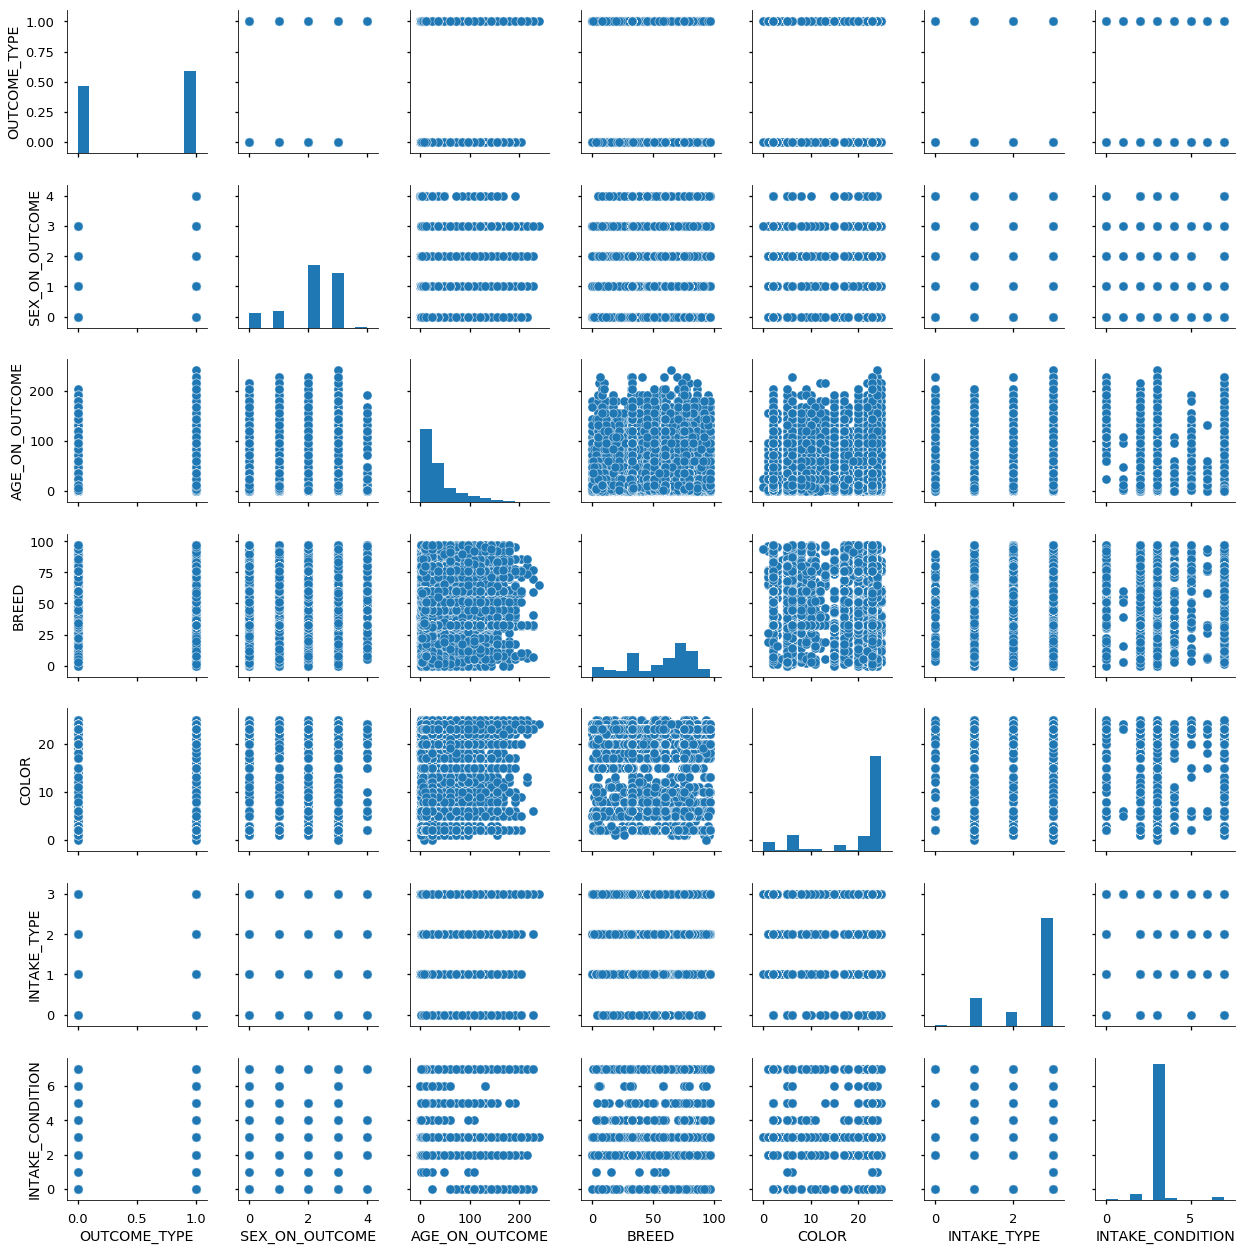

In [10]:
pairs=lowoccur_df.loc[:,['OUTCOME_TYPE', 'SEX_ON_OUTCOME', 'AGE_ON_OUTCOME', 'BREED', 'COLOR', 'INTAKE_TYPE', 'INTAKE_CONDITION']]

sns.pairplot(pairs)

### Initialize function to plot model results

In [41]:
def show_plots(model, X_test_std, y_test, y_train, folds=5):
    """
    Given a model and the test/train data, will plot the learning curves and ROC curves
    
    INPUTS:
    model - the model from sklearn to be utilized
    X_test_std - standardized X_test data from train/test split
    y_test - data from the train/test split
    y_train - data from the train/test split
    folds - how many cv folds to use when calculating a learning curve
    """
    train_sizes, train_scores, test_scores = learning_curve(model, X_test_std, y_test, cv=folds, scoring='neg_log_loss')
    train_cv_err = np.mean(train_scores, axis=1)
    test_cv_err = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_cv_err, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_cv_err, 'o-', color='k', label='Testing Score')
    plt.xlabel('Train Examples', fontsize=20)
    plt.ylabel('Score', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('Learning Curve', fontsize=24)
    plt.legend();
    
    y_train=np.ravel(y_train)
    log = model.fit(X_train_std, y_train)
    y_score=log.predict_proba(X_test_std)[:,0]
    fpr, tpr,_ = roc_curve(y_test, y_score, pos_label=0)
    roc_auc = auc(fpr, tpr)
    print('ROC_AUC:  ' + str(roc_auc))
    
    plt.figure()
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr)
    plt.xlabel('FPR', fontsize=20)
    plt.ylabel('TPR', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('ROC Curve', fontsize=24);

### Pick the desired features and targets and standardize data

In [12]:
X=lowoccur_df.loc[:,['SEX_ON_OUTCOME', 'AGE_ON_OUTCOME', 'BREED', 'COLOR', 'INTAKE_TYPE', 'INTAKE_CONDITION']]
y=lowoccur_df['OUTCOME_TYPE']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=4444)
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

## Start Modeling with Random Forest (as this was the best model in part 4 modeling)

#### Random Forest

In [14]:
RF_model = RandomForestClassifier(class_weight='balanced', random_state=4444)
RF_model.fit(X_train_std, y_train)
y_pred = RF_model.predict(X_test_std)
y_pred2 = RF_model.predict_proba(X_test_std)
print('RF Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('RF Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

RF Accuracy:  0.70566924508
RF Log Loss score:  1.55617925074
             precision    recall  f1-score   support

          0       0.66      0.75      0.70      4680
          1       0.76      0.67      0.71      5533

avg / total       0.71      0.71      0.71     10213



ROC_AUC:  0.859257798199


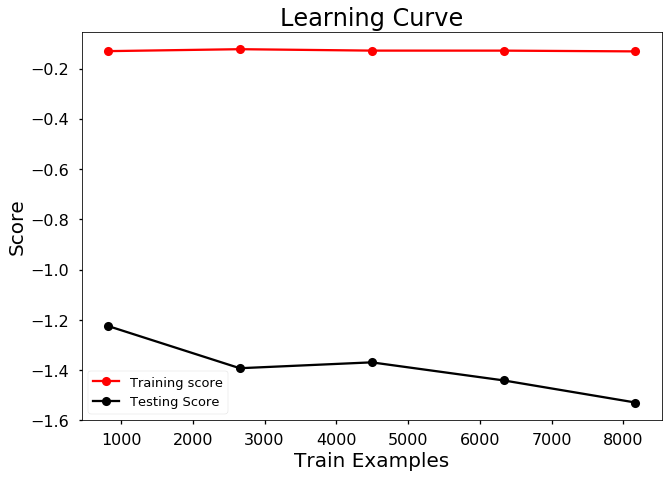

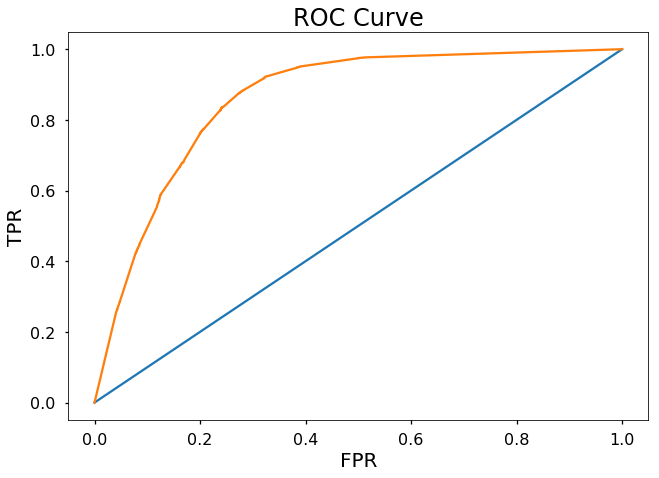

In [42]:
show_plots(RF_model, X_test_std, y_test, y_train, folds=5)

In [16]:
RF_model.feature_importances_

array([ 0.27531605,  0.23528459,  0.27290821,  0.12027507,  0.07013672,
        0.02607935])

Features are: 'SEX_ON_OUTCOME', 'AGE_ON_OUTCOME', 'BREED', 'COLOR', 'INTAKE_TYPE', 'INTAKE_CONDITION'

#### Therefore sex, age, breed, and color are the most important

### Optimize Random Forest

#### Step 1.) target log loss as scoring metric

In [17]:
from scipy.stats import randint as sp_randint
param_dist = {"n_estimators": sp_randint(1, 200),
              "criterion": ['gini', 'entropy'],
              "max_depth": sp_randint(1, 100)}
RF_model = RandomForestClassifier(class_weight='balanced', random_state=4444)
random_search = RandomizedSearchCV(RF_model, param_distributions=param_dist, scoring='neg_log_loss', n_iter=20)

In [18]:
random_search.fit(X_train_std, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=4444,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11649ff60>, 'criterion': ['gini', 'entropy'], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11591b630>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='neg_log_loss', verbose=0)

In [19]:
random_search.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 54}

In [20]:
random_search.best_score_

-0.5257604845730756

In [21]:
RF_model = RandomForestClassifier(class_weight='balanced', criterion='entropy', random_state=4444)
parameters = {'max_depth': [4, 6, 8, 10, 12], 'n_estimators': [30, 40, 50, 60, 70]}
grid = GridSearchCV(RF_model,parameters, cv=5, scoring='neg_log_loss', n_jobs=1)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=4444,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 6, 8, 10, 12], 'n_estimators': [30, 40, 50, 60, 70]},
       pre_dispatch='2*n_jobs', refit=True, scoring='neg_log_loss',
       verbose=0)

In [22]:
best_RF = grid.best_estimator_

In [23]:
y_pred = best_RF.predict(X_test_std)
y_pred2 = best_RF.predict_proba(X_test_std)
print('RF Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('RF Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

RF Accuracy:  0.735631058455
RF Log Loss score:  0.508814461494
             precision    recall  f1-score   support

          0       0.67      0.85      0.75      4680
          1       0.83      0.64      0.72      5533

avg / total       0.76      0.74      0.73     10213



ROC_AUC:  0.88209497869


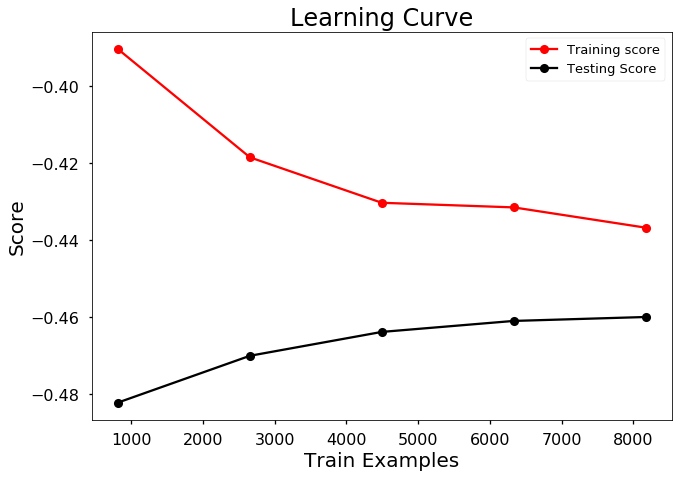

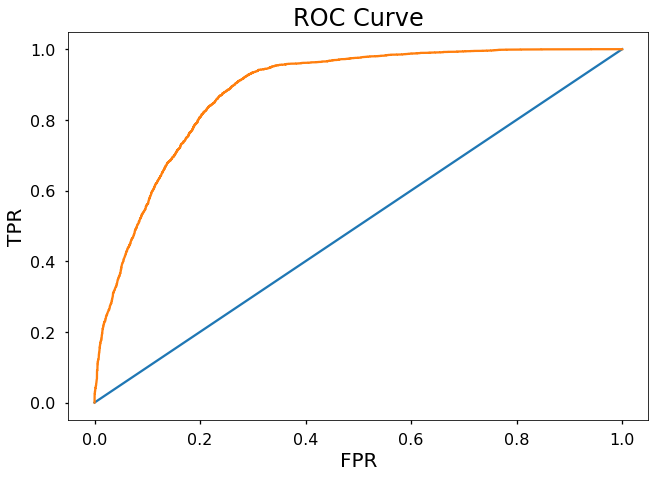

In [43]:
show_plots(best_RF, X_test_std, y_test, y_train, folds=5)

In [25]:
best_RF.feature_importances_

array([ 0.51002746,  0.254536  ,  0.05960084,  0.03118019,  0.11743609,
        0.02721941])

Features = 'SEX_ON_OUTCOME', 'AGE_ON_OUTCOME', 'BREED', 'COLOR', 'INTAKE_TYPE', 'INTAKE_CONDITION'

Therefore sex, age, and intake type are most important

In [ ]:
importances = np.array([0.35655986, 0.29198319, 0.12628095, 0.04670698, 0.02327132, 0.13871104, 0.01648666])

x = np.arange(7)
plt.bar(x, height=(importances*100))
plt.xticks(x, ['Time', 'Sex', 'Age', 'Breed', 'Color', 'Intake Type', 'Intake Cond'], fontsize=20, rotation=90)
plt.yticks(fontsize=18)
plt.ylabel('Importance (%)', fontsize=26)
save_path = '/Users/murdock/Documents/metis/project3/RFfeat_imp.png'
plt.savefig(save_path, bbox_inches='tight');

In [28]:
len(y_pred2[:,0])

10213

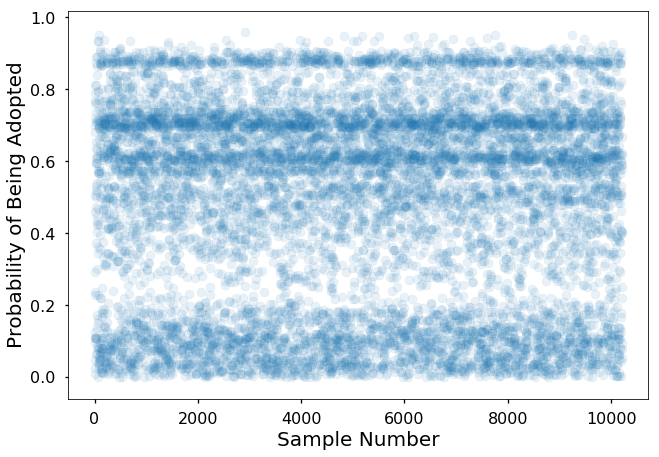

In [29]:
x = [i for i in range(1, 10214)]
plt.scatter(x, y_pred2[:,0], alpha=0.1)
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Probability of Being Adopted', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
save_path = '/Users/murdock/Documents/metis/project3/rfpredictproba.png'
plt.savefig(save_path, bbox_inches='tight');

## Before looking at other models, need to load dataframe with dummy variables instead of label encoding

In [30]:
path5 = '/Users/murdock/Documents/metis/project3/lowoccur_with_dummies.pkl'
lowoccur_dummy_df = pd.read_pickle(path5)

In [31]:
lowoccur_dummy_df.head()

,TIME_DIFF,OUTCOME_TYPE,AGE_ON_OUTCOME,AGE_ON_INTAKE,SEX_ON_OUTCOME_Intact Female,SEX_ON_OUTCOME_Intact Male,SEX_ON_OUTCOME_Neutered Male,SEX_ON_OUTCOME_Spayed Female,SEX_ON_OUTCOME_Unknown,BREED_American Bulldog Mix,...,INTAKE_CONDITION_Normal,INTAKE_CONDITION_Nursing,INTAKE_CONDITION_Other,INTAKE_CONDITION_Pregnant,INTAKE_CONDITION_Sick,SEX_ON_INTAKE_Intact Female,SEX_ON_INTAKE_Intact Male,SEX_ON_INTAKE_Neutered Male,SEX_ON_INTAKE_Spayed Female,SEX_ON_INTAKE_Unknown
0,0,1,84.0,84.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,4,1,120.0,120.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,1,192.0,192.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,1,180.0,180.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,180.0,180.0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [32]:
X = lowoccur_dummy_df[lowoccur_dummy_df.columns.difference(['OUTCOME_TYPE'])]
y= lowoccur_dummy_df['OUTCOME_TYPE']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=4444)
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

### Start Modeling with KNN

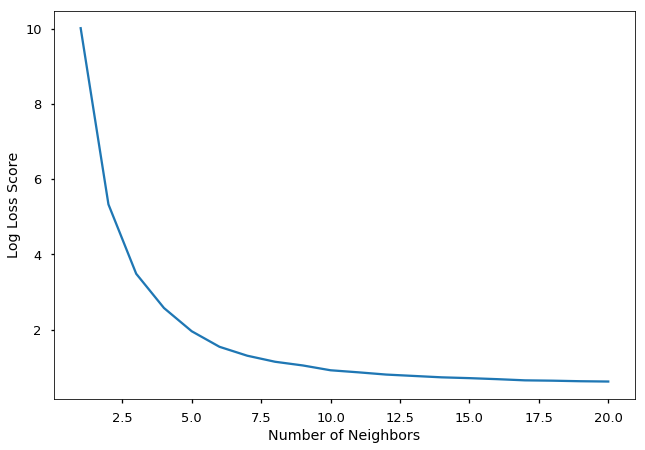

In [36]:
neighbors = np.arange(1, 21)
log_loss_scores = []

for number in neighbors:
    knn = KNeighborsClassifier(n_neighbors=number)
    knn.fit(X_train_std, y_train)
    y_pred = knn.predict_proba(X_test_std)
    log_loss_scores.append(log_loss(y_test, y_pred))

plt.plot(neighbors, log_loss_scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Log Loss Score');

In [37]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
y_pred2 = knn.predict_proba(X_test_std)
print('KNN Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('KNN Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

KNN Accuracy:  0.722608440223
KNN Log Loss score:  0.706932228619
             precision    recall  f1-score   support

          0       0.68      0.76      0.71      4680
          1       0.77      0.69      0.73      5533

avg / total       0.73      0.72      0.72     10213



ROC_AUC:  0.798370905105


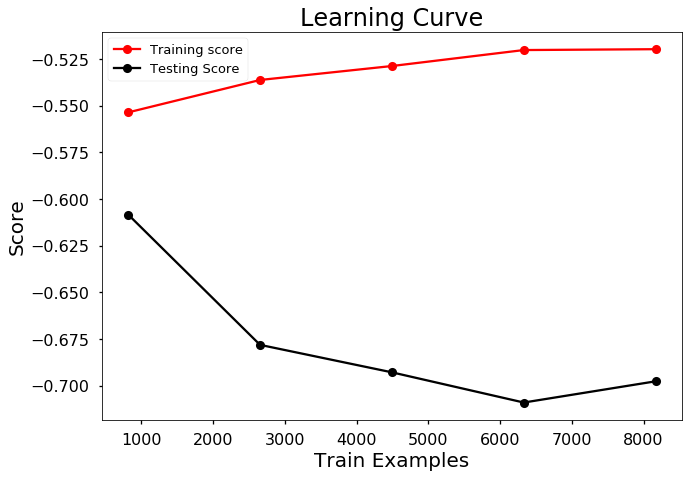

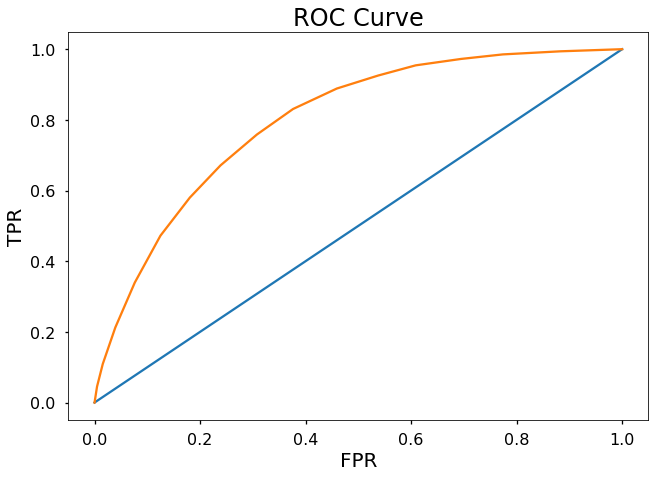

In [44]:
show_plots(knn, X_test_std, y_test, y_train, folds=5)

### Try Logistic Regression

In [39]:
logreg = LogisticRegression()
logreg.fit(X_train_std, y_train)
y_pred = logreg.predict(X_test_std)
y_pred2 = logreg.predict_proba(X_test_std)
print('Logistic Regression Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('Logistic Regression Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy:  0.78311955351
Logistic Regression Log Loss score:  0.470407268668
             precision    recall  f1-score   support

          0       0.75      0.80      0.77      4680
          1       0.82      0.77      0.79      5533

avg / total       0.79      0.78      0.78     10213



ROC_AUC:  0.853644739952


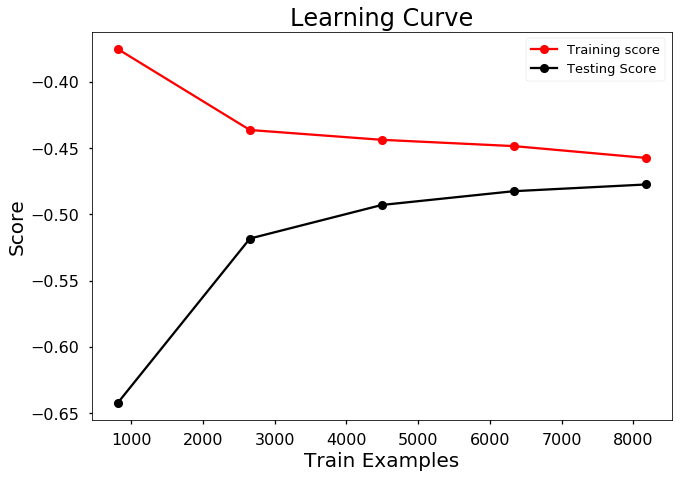

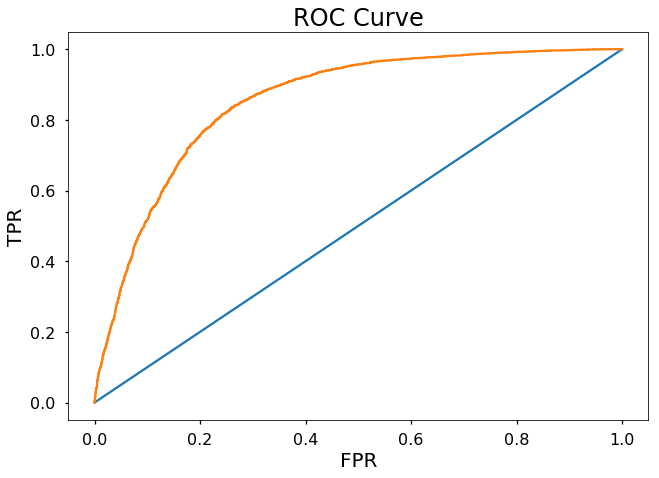

In [45]:
show_plots(logreg, X_test_std, y_test, y_train, folds=5)

### Optimize Logistic Regression

#### Step 1.) target log loss as scoring metric

In [59]:
from scipy.stats import randint as sp_randint
param_dist = {"penalty": ['l1', 'l2'],
              "C": sp_randint(1, 100),
              "fit_intercept": [True, False]}
logreg = LogisticRegression()
random_search = RandomizedSearchCV(logreg, param_distributions=param_dist, scoring='neg_log_loss', n_iter=20, cv=5)

In [60]:
random_search.fit(X_train_std, y_train)

/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: R

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11ad28eb8>, 'fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='neg_log_loss', verbose=0)

In [61]:
random_search.best_params_

{'C': 81, 'fit_intercept': True, 'penalty': 'l1'}

In [62]:
random_search.best_score_

-0.47710655687692227

In [63]:
logreg = LogisticRegression()
parameters = {"C": [70, 75, 80, 85, 90], "penalty": ['l1', 'l2']}
grid = GridSearchCV(logreg,parameters, cv=5, scoring='neg_log_loss', n_jobs=1)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [70, 75, 80, 85, 90], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, scoring='neg_log_loss',
       verbose=0)

In [64]:
best_logreg = grid.best_estimator_

In [65]:
y_pred = best_logreg.predict(X_test_std)
y_pred2 = best_logreg.predict_proba(X_test_std)
print('Logistic Regression Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('Logistic Regression Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy:  0.783217467933
Logistic Regression Log Loss score:  0.470602768472
             precision    recall  f1-score   support

          0       0.75      0.80      0.77      4680
          1       0.82      0.77      0.79      5533

avg / total       0.79      0.78      0.78     10213



ROC_AUC:  0.853612030227


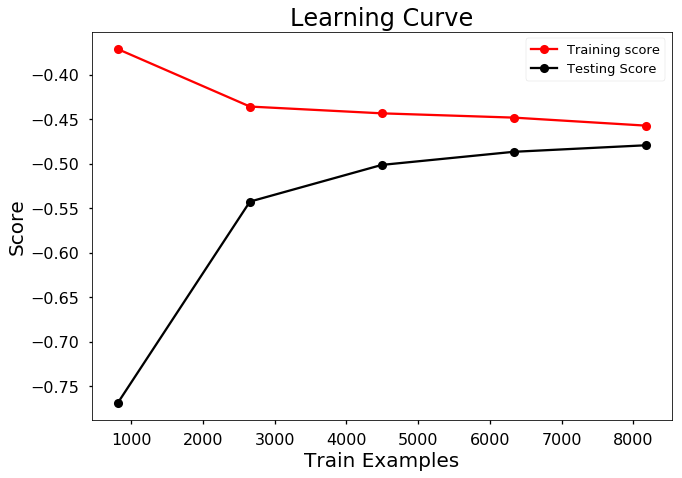

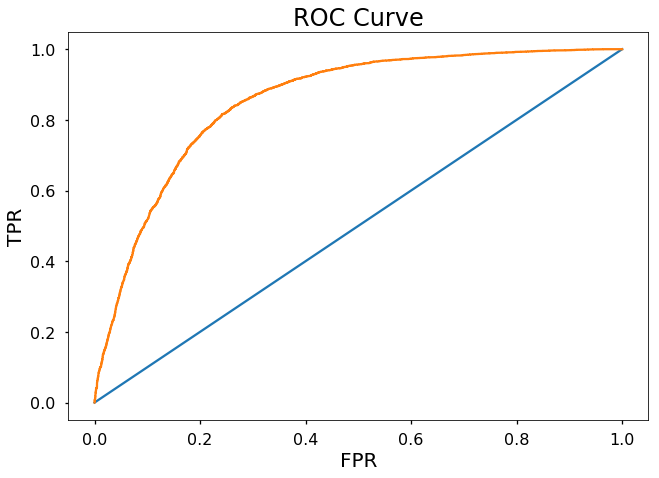

In [66]:
show_plots(best_logreg, X_test_std, y_test, y_train, folds=5)

### Graph probabilities

In [67]:
len(y_pred2[:,0])

10213

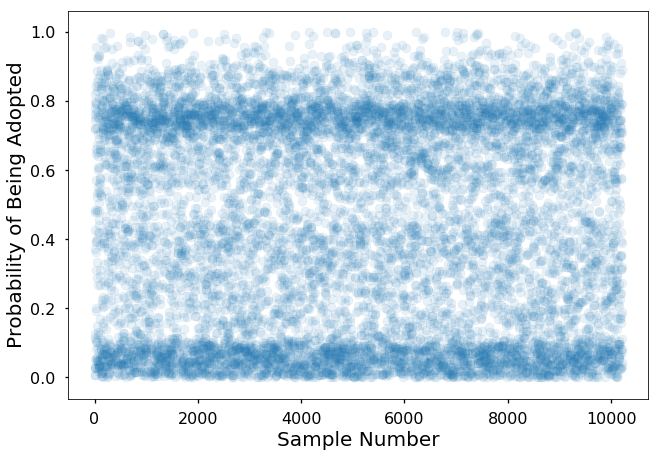

In [69]:
x = [i for i in range(1, 10214)]
plt.scatter(x, y_pred2[:,0], alpha=0.1)
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Probability of Being Adopted', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
save_path = '/Users/murdock/Documents/metis/project3/rfpredictprobaday1.png'
plt.savefig(save_path, bbox_inches='tight');

### This model is the best so lets fit it to the entire data set and pickle it for later!

In [73]:
best_logreg.fit(X,y)

LogisticRegression(C=75, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
import pickle

path = '/Users/murdock/Documents/metis/project3/'
# Dump the trained classifier with Pickle
pkl_filename = 'logistic_regression_day1.pkl'
# Open the file to save as pkl file
model_pkl = open(path + pkl_filename, 'wb')
pickle.dump(best_logreg, model_pkl)
# Close the pickle instances
model_pkl.close()

### Try Naive Bayes

In [72]:
from sklearn.naive_bayes import MultinomialNB

bayes_model = MultinomialNB()
bayes_model.fit(X_train, y_train)
y_pred = bayes_model.predict(X_test)
y_pred2 = bayes_model.predict_proba(X_test)
print('Bayes Model Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('Bayes Model Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

Bayes Model Accuracy:  0.707235875845
Bayes Model Log Loss score:  3.58868750625
             precision    recall  f1-score   support

          0       0.69      0.65      0.67      4680
          1       0.72      0.76      0.74      5533

avg / total       0.71      0.71      0.71     10213



## Logistic Regression (with accuracy as a scoring metric) was the best model with an accuracy of ~78%.